In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
from geopy.distance import geodesic
from io import StringIO

In [21]:
def load_bridge_data(csv_file_path):
    """Load bridge sensor data from CSV file"""
    df = pd.read_csv(csv_file_path)
    return df

In [22]:
def calculate_3d_distance(coord1, coord2):
    """Calculate 3D distance considering lat, lon, and altitude"""
 
    horizontal_dist = geodesic((coord1[0], coord1[1]), (coord2[0], coord2[1])).meters
    vertical_dist = abs(coord1[2] - coord2[2])
    distance_3d = np.sqrt(horizontal_dist**2 + vertical_dist**2)
    
    return distance_3d

In [23]:
def get_stiffness_value(src_type, tgt_type, distance_m):
    """
    Get stiffness value based on structural element types and distance
    pier: 1.2, girder: 1.0, pylon: 1.5, ground: 0.8
    """
    # Define base stiffness for each type
    type_stiffness = {
        'pier': 1.2,
        'girder': 1.0, 
        'pylon': 1.5,
        'ground': 0.8
    }
    

    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.1 
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.3 
    

    if src_type == tgt_type:
        base_stiffness = type_stiffness.get(src_type, 1.0)

        distance_factor = max(0.5, 1.0 - (distance_m / 500.0)) 
        return round(base_stiffness * distance_factor, 2)
    

    src_stiff = type_stiffness.get(src_type, 1.0)
    tgt_stiff = type_stiffness.get(tgt_type, 1.0)
    return round((src_stiff + tgt_stiff) / 2, 2)

In [24]:
def calculate_structural_penalty(src_type, tgt_type):
    """
    Calculate penalty for structurally important connections
    Lower penalty = higher priority in MST
    """
   
    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 0.1 
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 0.05 
    
  
    if src_type == tgt_type:
        type_priorities = {'pylon': 0.3, 'girder': 0.4, 'pier': 0.5, 'ground': 0.7}
        return type_priorities.get(src_type, 0.6)
    

    return 0.8

In [25]:
def create_complete_graph_with_weights(df):
    """Create a complete graph with all possible edges and their weights"""
    coords = df[['latitude', 'longitude', 'altitude_m']].values
    node_ids = df['node_id'].tolist()
    n_nodes = len(df)
    
    all_edges = []
    
    print(f"\nCreating complete graph with {n_nodes} nodes...")
    print(f"Total possible edges: {n_nodes * (n_nodes - 1) // 2}")
    
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            src_id = node_ids[i]
            tgt_id = node_ids[j]
            src_type = df.iloc[i]['type']
            tgt_type = df.iloc[j]['type']
            

            distance = calculate_3d_distance(coords[i], coords[j])
            
 
            structural_penalty = calculate_structural_penalty(src_type, tgt_type)
            

            weight = distance * structural_penalty
            

            stiffness = get_stiffness_value(src_type, tgt_type, distance)
            
      
            if src_type == tgt_type:
                edge_type = src_type
            else:
                edge_type = "support"
            
            all_edges.append({
                'source': src_id,
                'target': tgt_id,
                'weight': weight,
                'distance_m': round(distance, 2),
                'structural_penalty': structural_penalty,
                'type': edge_type,
                'stiffness': stiffness,
                'src_type': src_type,
                'tgt_type': tgt_type
            })
    
    return all_edges

In [27]:
def create_mst_edges(df, algorithm='kruskal'):
    """
    Create edges using Minimum Spanning Tree algorithms
    Options: 'kruskal', 'prim'
    """
    print(f"\n=== MST Edge Creation using {algorithm.title()}'s Algorithm ===")
    

    all_edges = create_complete_graph_with_weights(df)
    

    G_complete = nx.Graph()
    

    for _, row in df.iterrows():
        G_complete.add_node(row['node_id'], 
                           type=row['type'],
                           pos=(row['longitude'], row['latitude']),
                           altitude=row['altitude_m'])
    
  
    for edge in all_edges:
        G_complete.add_edge(edge['source'], edge['target'], 
                           weight=edge['weight'],
                           distance_m=edge['distance_m'],
                           structural_penalty=edge['structural_penalty'],
                           type=edge['type'],
                           stiffness=edge['stiffness'],
                           src_type=edge['src_type'],
                           tgt_type=edge['tgt_type'])
    
    # Apply MST algorithm
    if algorithm == 'kruskal':
        mst_edges = nx.minimum_spanning_tree(G_complete, algorithm='kruskal')
    else:  # prim
        mst_edges = nx.minimum_spanning_tree(G_complete, algorithm='prim')
    
    # Convert MST edges back to our format
    mst_edge_list = []
    total_weight = 0
    total_distance = 0
    
    print(f"\nMST Edges Selected:")
    print(f"{'Source':<8} {'Target':<8} {'Type':<8} {'Distance':<10} {'Penalty':<10} {'Weight':<10} {'Stiffness'}")
    print("-" * 80)
    
    for edge in mst_edges.edges(data=True):
        src, tgt, data = edge
        mst_edge_list.append({
            'source': src,
            'target': tgt,
            'type': data['type'],
            'stiffness': data['stiffness'],
            'distance_m': data['distance_m'],
            'structural_penalty': data['structural_penalty'],
            'weight': data['weight'],
            'src_type': data['src_type'],
            'tgt_type': data['tgt_type']
        })
        
        total_weight += data['weight']
        total_distance += data['distance_m']
        
        print(f"{src:<8} {tgt:<8} {data['type']:<8} {data['distance_m']:<10.1f} "
              f"{data['structural_penalty']:<10.2f} {data['weight']:<10.1f} {data['stiffness']}")
    
    print(f"\nMST Summary:")
    print(f"Total edges in MST: {len(mst_edge_list)}")
    print(f"Total distance: {total_distance:.1f}m")
    print(f"Total weighted cost: {total_weight:.1f}")
    print(f"Average edge distance: {total_distance/len(mst_edge_list):.1f}m")
    
    return mst_edge_list, mst_edges


In [28]:
def create_enhanced_mst(df, connectivity_factor=1.5):
    """
    Create Enhanced MST by adding critical structural connections
    beyond basic MST to improve structural integrity
    """
    print(f"\n=== Enhanced MST (Connectivity Factor: {connectivity_factor}) ===")
    

    mst_edges, mst_graph = create_mst_edges(df, 'kruskal')
    

    all_edges = create_complete_graph_with_weights(df)
    

    all_edges.sort(key=lambda x: (x['structural_penalty'], x['distance_m']))
    

    target_edges = int(len(df) * connectivity_factor)
    current_edges = len(mst_edges)
    
    print(f"Basic MST edges: {current_edges}")
    print(f"Target edges: {target_edges}")
    print(f"Adding {target_edges - current_edges} additional edges...")
    
    # Create set of existing edges for quick lookup
    existing_edges = set()
    for edge in mst_edges:
        edge_tuple = tuple(sorted((edge['source'], edge['target'])))
        existing_edges.add(edge_tuple)
    
    enhanced_edges = mst_edges.copy()
    added_count = 0
    
    print(f"\nAdditional edges added:")
    print(f"{'Source':<8} {'Target':<8} {'Type':<8} {'Distance':<10} {'Penalty':<10} {'Reason'}")
    print("-" * 75)
    
    for edge in all_edges:
        if added_count >= (target_edges - current_edges):
            break
            
        edge_tuple = tuple(sorted((edge['source'], edge['target'])))
        if edge_tuple not in existing_edges:
            # Add this edge if it's structurally important
            reason = ""
            should_add = False
            
            # Critical structural connections
            if edge['structural_penalty'] <= 0.2:
                should_add = True
                reason = "Critical structural"
            # Important same-type connections for redundancy
            elif edge['structural_penalty'] <= 0.4 and edge['distance_m'] < 50:
                should_add = True
                reason = "Short same-type"
            # Add some longer connections for robustness
            elif added_count < (target_edges - current_edges) * 0.3:
                should_add = True
                reason = "Network robustness"
            
            if should_add:
                enhanced_edges.append(edge)
                existing_edges.add(edge_tuple)
                added_count += 1
                
                print(f"{edge['source']:<8} {edge['target']:<8} {edge['type']:<8} "
                      f"{edge['distance_m']:<10.1f} {edge['structural_penalty']:<10.2f} {reason}")
    
    print(f"\nEnhanced MST Summary:")
    print(f"Total edges: {len(enhanced_edges)}")
    total_distance = sum(e['distance_m'] for e in enhanced_edges)
    print(f"Total distance: {total_distance:.1f}m")
    print(f"Average edge distance: {total_distance/len(enhanced_edges):.1f}m")
    
    return enhanced_edges

In [29]:
def analyze_mst_connections(df, edges):
    """Analyze the MST connections"""
    print(f"\n=== MST Connection Analysis ===")
    

    connection_counts = {}
    structural_connections = 0
    
    for edge in edges:
        edge_type = edge['type']
        connection_counts[edge_type] = connection_counts.get(edge_type, 0) + 1
        
        if edge['structural_penalty'] <= 0.2:  # Critical structural connections
            structural_connections += 1
    
    print("Connection types in MST:")
    for conn_type, count in sorted(connection_counts.items()):
        avg_stiffness = np.mean([e['stiffness'] for e in edges if e['type'] == conn_type])
        avg_distance = np.mean([e['distance_m'] for e in edges if e['type'] == conn_type])
        print(f"  {conn_type}: {count} edges (avg stiffness: {avg_stiffness:.2f}, avg distance: {avg_distance:.1f}m)")
    
    print(f"\nStructural integrity:")
    print(f"  Critical structural connections: {structural_connections}")
    print(f"  Support connections (cross-type): {len([e for e in edges if e['type'] == 'support'])}")
    
    # Show most important connections
    important_edges = sorted(edges, key=lambda x: x['structural_penalty'])[:8]
    print(f"\nMost critical connections in MST:")
    for i, edge in enumerate(important_edges, 1):
        print(f"  {i}. {edge['source']} ({edge['src_type']}) ↔ {edge['target']} ({edge['tgt_type']}) "
              f"- {edge['distance_m']:.1f}m (penalty: {edge['structural_penalty']:.2f})")

In [15]:
def save_edges_csv(edges, filename):
    """Save edges to CSV file"""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['source', 'target', 'type', 'stiffness', 'distance_m', 
                        'structural_penalty', 'weight', 'src_type', 'tgt_type'])
        for edge in edges:
            writer.writerow([edge['source'], edge['target'], edge['type'], 
                           edge['stiffness'], edge['distance_m'], edge['structural_penalty'],
                           edge['weight'], edge['src_type'], edge['tgt_type']])
    print(f"Edges saved to {filename}")


In [30]:
def create_networkx_graph(df, edges):
    """Create NetworkX graph from nodes and edges"""
    G = nx.Graph()
    
    # Add nodes with attributes
    for _, row in df.iterrows():
        G.add_node(row['node_id'], 
                  type=row['type'],
                  pos=(row['longitude'], row['latitude']),
                  altitude=row['altitude_m'])
    
    # Add edges with attributes
    for edge in edges:
        G.add_edge(edge['source'], edge['target'],
                  type=edge['type'],
                  stiffness=edge['stiffness'],
                  distance_m=edge['distance_m'],
                  structural_penalty=edge.get('structural_penalty', 0.5),
                  weight=edge.get('weight', edge['distance_m']))
    
    return G

In [31]:
def visualize_mst_network(G, df, title_suffix=""):
    """Create 2D and 3D visualizations of the MST network"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 2D Plot
    pos = nx.get_node_attributes(G, 'pos')
    
    # Color nodes by type
    node_colors = []
    color_map = {'girder': 'yellow', 'pier': 'cyan', 'ground': 'green', 'pylon': 'red'}
    for node in G.nodes():
        node_colors.append(color_map[G.nodes[node]['type']])
    
    # Color edges by structural importance
    edge_colors = []
    edge_widths = []
    
    for edge in G.edges():
        penalty = G.edges[edge].get('structural_penalty', 0.5)
        stiffness = G.edges[edge]['stiffness']
        
        # Critical connections in red, others by type
        if penalty <= 0.2:
            edge_colors.append('red')
            edge_widths.append(stiffness * 2.5)  # Thicker for critical
        elif penalty <= 0.4:
            edge_colors.append('orange')
            edge_widths.append(stiffness * 2.0)
        else:
            edge_colors.append('blue')
            edge_widths.append(stiffness * 1.5)
    
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color=node_colors, 
            edge_color=edge_colors, node_size=400, font_size=9, font_weight='bold', 
            width=edge_widths)
    ax1.set_title(f'Bridge Sensor Network - MST {title_suffix}\nRed=Critical, Orange=Important, Blue=Regular')
    
    # Create legend for nodes
    node_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                  for color in color_map.values()]
    ax1.legend(node_legend, list(color_map.keys()), loc='upper left', title='Nodes')
    
    # 3D Plot
    ax3d = fig.add_subplot(122, projection='3d')
    
    # Plot nodes in 3D
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        z = G.nodes[node]['altitude']
        color = color_map[G.nodes[node]['type']]
        ax3d.scatter(x, y, z, c=color, s=150)
        ax3d.text(x, y, z + 1, str(node), fontsize=8)
    
    # Draw edges in 3D
    for edge in G.edges():
        x_coords = [G.nodes[edge[0]]['pos'][0], G.nodes[edge[1]]['pos'][0]]
        y_coords = [G.nodes[edge[0]]['pos'][1], G.nodes[edge[1]]['pos'][1]]
        z_coords = [G.nodes[edge[0]]['altitude'], G.nodes[edge[1]]['altitude']]
        
        penalty = G.edges[edge].get('structural_penalty', 0.5)
        stiffness = G.edges[edge]['stiffness']
        
        # Color and thickness based on structural importance
        if penalty <= 0.2:
            color = 'red'
            linewidth = stiffness * 2.5
        elif penalty <= 0.4:
            color = 'orange'
            linewidth = stiffness * 2.0
        else:
            color = 'blue'
            linewidth = stiffness * 1.5
            
        ax3d.plot(x_coords, y_coords, z_coords, color=color, 
                 alpha=0.8, linewidth=linewidth)
    
    ax3d.set_xlabel('Longitude')
    ax3d.set_ylabel('Latitude')
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title(f'Bridge Sensor Network - MST 3D {title_suffix}')
    
    # Set proper aspect ratio for bridge visualization
    ax3d.set_box_aspect([4,2,1])
    
    plt.tight_layout()
    plt.show()

In [32]:
def analyze_graph_properties(G, graph_type="MST"):
    """Analyze and print graph properties"""
    print(f"\n=== {graph_type} Network Analysis ===")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G):.3f}")
    print(f"Is connected: {nx.is_connected(G)}")
    
    if nx.is_connected(G):
        print(f"Average shortest path length: {nx.average_shortest_path_length(G):.2f}")
        print(f"Network diameter: {nx.diameter(G)}")
    
    # Node type distribution
    node_types = {}
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print(f"\nNode type distribution:")
    for node_type, count in node_types.items():
        avg_degree = np.mean([G.degree[n] for n in G.nodes() if G.nodes[n]['type'] == node_type])
        print(f"  {node_type}: {count} nodes (avg degree: {avg_degree:.1f})")


=== Shin-Nakagawa Bridge Sensor Network - MST Analysis ===
Loaded bridge sensor data:
Total sensors: 26
Sensor types: {'girder': 12, 'pier': 8, 'ground': 6}

=== MST Algorithm Benefits ===
✓ Ensures network connectivity with minimum total cost
✓ Prioritizes structurally critical connections
✓ Eliminates redundant long-distance connections
✓ Optimizes for both structural integrity and efficiency

MST Analysis using Kruskal's Algorithm

=== MST Edge Creation using Kruskal's Algorithm ===

Creating complete graph with 26 nodes...
Total possible edges: 325

MST Edges Selected:
Source   Target   Type     Distance   Penalty    Weight     Stiffness
--------------------------------------------------------------------------------
22       23       support  4.9        0.10       0.5        1.1
22       24       support  15.2       0.10       1.5        1.1
26       27       support  3.8        0.10       0.4        1.1
26       28       support  20.1       0.10       2.0        1.1
30       31  

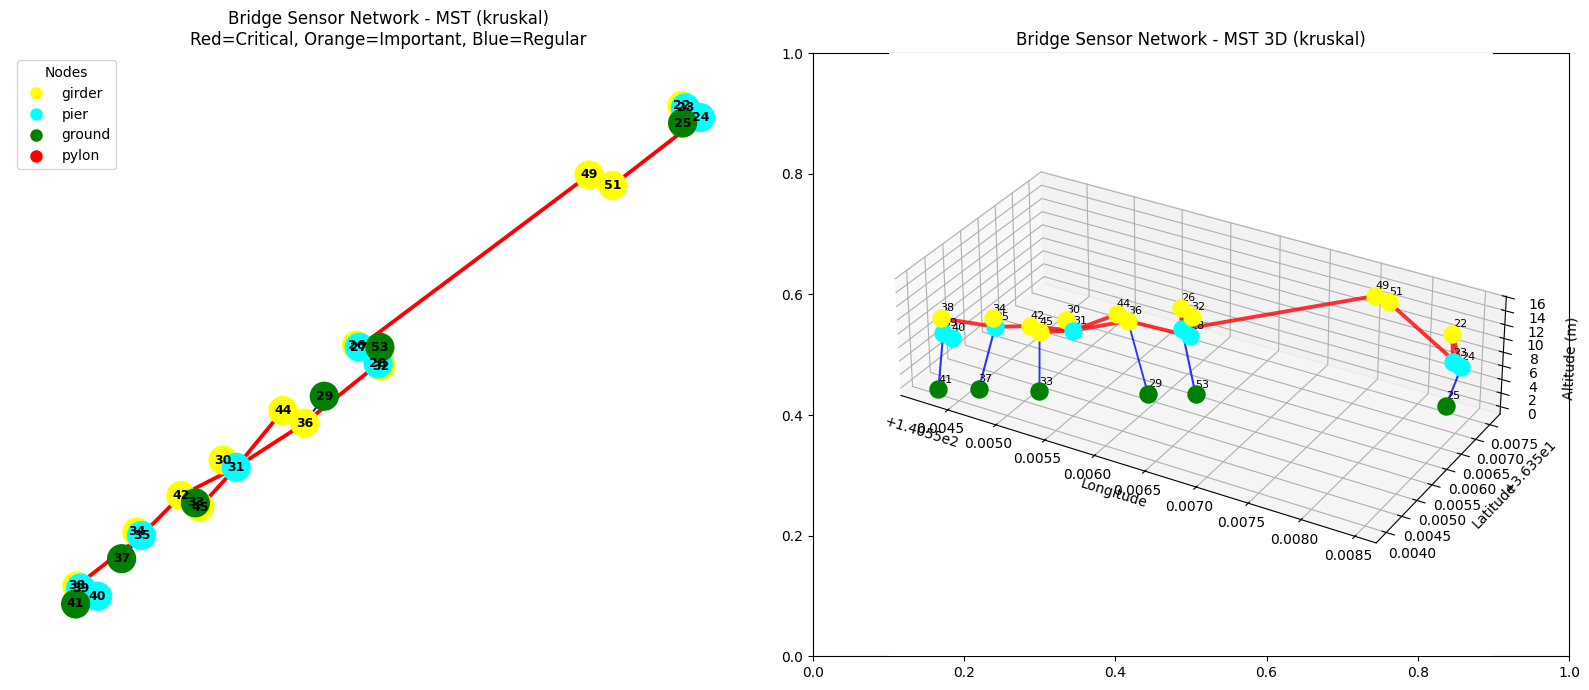


----------------------------------------
Enhanced MST (Factor: 1.3)
----------------------------------------

=== Enhanced MST (Connectivity Factor: 1.3) ===

=== MST Edge Creation using Kruskal's Algorithm ===

Creating complete graph with 26 nodes...
Total possible edges: 325

MST Edges Selected:
Source   Target   Type     Distance   Penalty    Weight     Stiffness
--------------------------------------------------------------------------------
22       23       support  4.9        0.10       0.5        1.1
22       24       support  15.2       0.10       1.5        1.1
26       27       support  3.8        0.10       0.4        1.1
26       28       support  20.1       0.10       2.0        1.1
30       31       support  9.8        0.10       1.0        1.1
32       28       support  3.8        0.10       0.4        1.1
34       35       support  4.0        0.10       0.4        1.1
36       31       support  54.0       0.10       5.4        1.1
36       28       support  64.8     

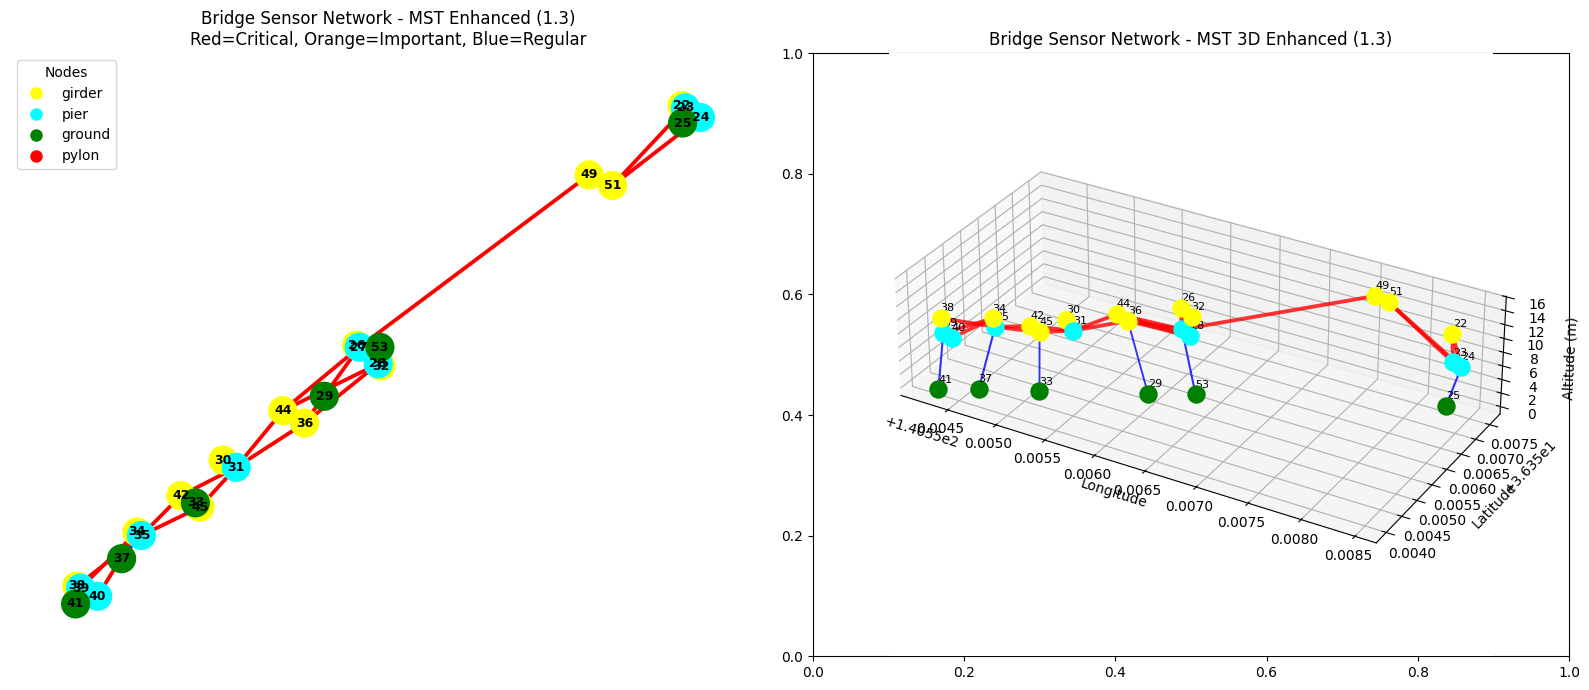


----------------------------------------
Enhanced MST (Factor: 1.6)
----------------------------------------

=== Enhanced MST (Connectivity Factor: 1.6) ===

=== MST Edge Creation using Kruskal's Algorithm ===

Creating complete graph with 26 nodes...
Total possible edges: 325

MST Edges Selected:
Source   Target   Type     Distance   Penalty    Weight     Stiffness
--------------------------------------------------------------------------------
22       23       support  4.9        0.10       0.5        1.1
22       24       support  15.2       0.10       1.5        1.1
26       27       support  3.8        0.10       0.4        1.1
26       28       support  20.1       0.10       2.0        1.1
30       31       support  9.8        0.10       1.0        1.1
32       28       support  3.8        0.10       0.4        1.1
34       35       support  4.0        0.10       0.4        1.1
36       31       support  54.0       0.10       5.4        1.1
36       28       support  64.8     

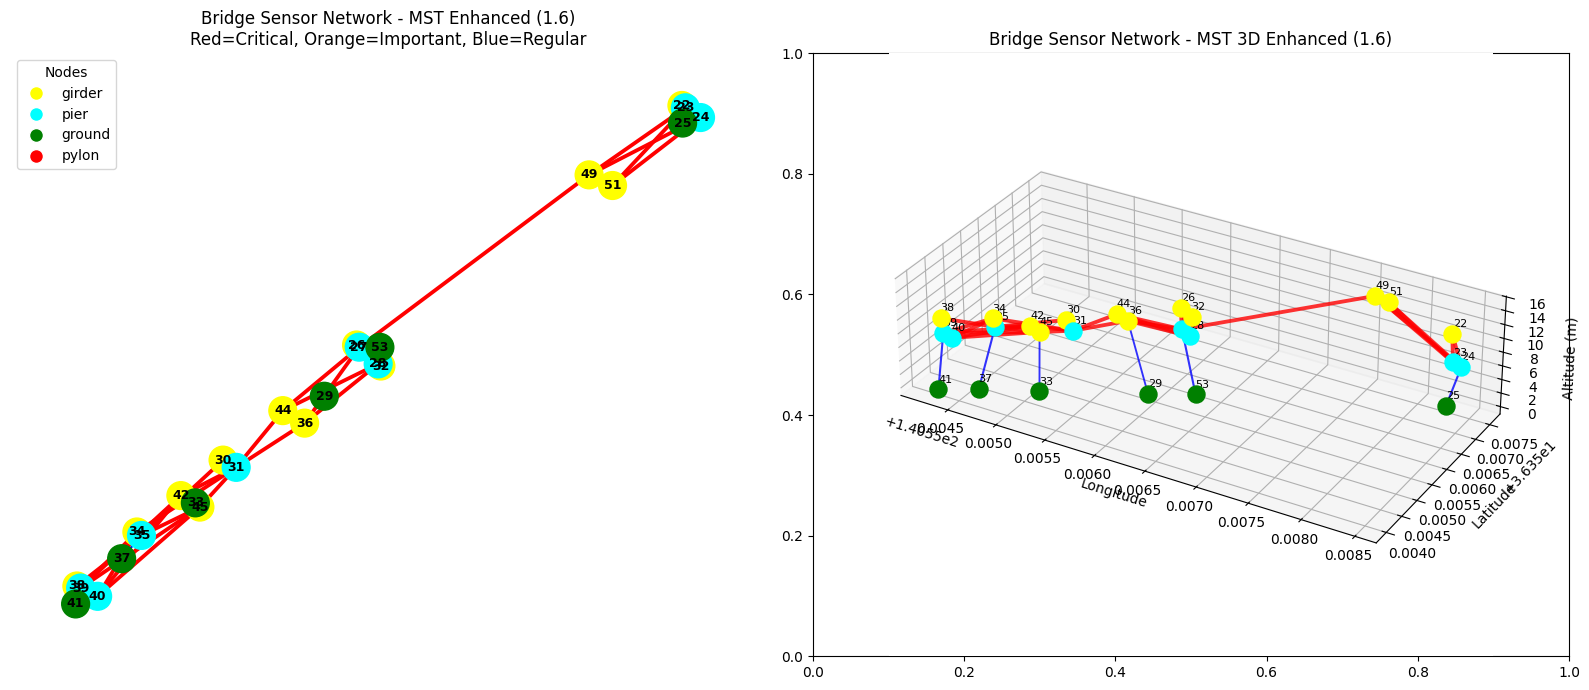


=== MST Analysis Complete ===
Files generated:
  - bridge_edges_mst_kruskal.csv (Pure MST)
  - bridge_edges_enhanced_mst_1.3.csv (Enhanced)
  - bridge_edges_enhanced_mst_1.6.csv (Enhanced)

Recommendations:
• Pure MST: Minimum edges for connectivity, structurally optimized
• Enhanced MST 1.3: Good balance of efficiency and redundancy
• Enhanced MST 1.6: Higher redundancy for fault tolerance
• MST algorithms prioritize pier-girder and pylon-girder connections!


In [33]:
if __name__ == "__main__":
    # Bridge sensor data
    csv_data = """node_id,type,latitude,longitude,altitude_m
22,girder,36.35760246,140.5582758,10
26,girder,36.35584565,140.5561452,12
30,girder,36.35500155,140.555271,10
32,girder,36.35569158,140.5563046,12
34,girder,36.35447425,140.5547067,10
36,girder,36.35527276,140.5558051,11
38,girder,36.35407821,140.5543137,10
42,girder,36.35474124,140.5549947,9
44,girder,36.35536433,140.5556622,11
45,girder,36.3546569,140.5551193,9
49,girder,36.35709344,140.5576679,15
51,girder,36.35701549,140.5578214,15
23,pier,36.35758548,140.5582983,6
24,pier,36.35751402,140.5583976,6
27,pier,36.35582977,140.5561624,9
28,pier,36.35570737,140.5562867,9
31,pier,36.35494837,140.5553569,9
35,pier,36.35444892,140.5547367,9
39,pier,36.35406326,140.5543382,8
40,pier,36.35400257,140.5544497,8
25,ground,36.3574735,140.5582802,0
29,ground,36.35546989,140.555934,0
33,ground,36.35468793,140.5550896,0
37,ground,36.35427857,140.5546068,0
41,ground,36.35394661,140.5543055,0
53,ground,36.35582872,140.556298,0"""

    # Load data
    df = pd.read_csv(StringIO(csv_data))
    
    print("=== Shin-Nakagawa Bridge Sensor Network - MST Analysis ===")
    print("Loaded bridge sensor data:")
    print(f"Total sensors: {len(df)}")
    print(f"Sensor types: {df['type'].value_counts().to_dict()}")
    
    print("\n=== MST Algorithm Benefits ===")
    print("✓ Ensures network connectivity with minimum total cost")
    print("✓ Prioritizes structurally critical connections")
    print("✓ Eliminates redundant long-distance connections")
    print("✓ Optimizes for both structural integrity and efficiency")
    
    # Create different MST variants
    algorithms = ['kruskal']  # Can add 'prim' if needed
    connectivity_factors = [1.0, 1.3, 1.6]  # 1.0 = pure MST, higher = more connected
    
    for algorithm in algorithms:
        print(f"\n{'='*60}")
        print(f"MST Analysis using {algorithm.title()}'s Algorithm")
        print(f"{'='*60}")
        
        # Pure MST
        mst_edges, mst_graph = create_mst_edges(df, algorithm)
        analyze_mst_connections(df, mst_edges)
        
        # Save pure MST
        filename = f'bridge_edges_mst_{algorithm}.csv'
        save_edges_csv(mst_edges, filename)
        
        # Create and analyze graph
        G_mst = create_networkx_graph(df, mst_edges)
        analyze_graph_properties(G_mst, f"MST ({algorithm})")
        visualize_mst_network(G_mst, df, f"({algorithm})")
        
        # Enhanced MST variants
        for factor in connectivity_factors[1:]:  # Skip 1.0 as it's pure MST
            print(f"\n{'-'*40}")
            print(f"Enhanced MST (Factor: {factor})")
            print(f"{'-'*40}")
            
            enhanced_edges = create_enhanced_mst(df, factor)
            analyze_mst_connections(df, enhanced_edges)
            
            # Save enhanced MST
            filename = f'bridge_edges_enhanced_mst_{factor:.1f}.csv'
            save_edges_csv(enhanced_edges, filename)
            
            # Create and analyze enhanced graph
            G_enhanced = create_networkx_graph(df, enhanced_edges)
            analyze_graph_properties(G_enhanced, f"Enhanced MST ({factor})")
            visualize_mst_network(G_enhanced, df, f"Enhanced ({factor})")
    
    print(f"\n{'='*60}")
    print("=== MST Analysis Complete ===")
    print("Files generated:")
    print("  - bridge_edges_mst_kruskal.csv (Pure MST)")
    for factor in connectivity_factors[1:]:
        print(f"  - bridge_edges_enhanced_mst_{factor:.1f}.csv (Enhanced)")
    
    print("\nRecommendations:")
    print("• Pure MST: Minimum edges for connectivity, structurally optimized")
    print("• Enhanced MST 1.3: Good balance of efficiency and redundancy")
    print("• Enhanced MST 1.6: Higher redundancy for fault tolerance")
    print("• MST algorithms prioritize pier-girder and pylon-girder connections!")